In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# import csv
# import scipy
# import string
from scipy.stats import spearmanr
import glob
import re

In [3]:
keepcolsgfp = ['DNAseq', 
            'numreads_per_AD_1AGFP', 'Activity_1AGFP', 'numreads_per_AD_4BGFP', 'Activity_4BGFP',
        
           ]

keepcolscherry = ['DNAseq', 
            'numreads_per_AD_2AmCh', 'Activity_2AmCh', 'numreads_per_AD_5BmCh', 'Activity_5BmCh',
           ]

keepcolsratio = ['DNAseq', 
            'numreads_per_AD_3ARatio_redoseq', 'Activity_3ARatio_redoseq', 'numreads_per_AD_6BRatio', 'Activity_6BRatio'
           ]

FACSgfp = pd.read_csv('BYS4combined.csv', usecols=keepcolsgfp)
print(FACSgfp.dropna().shape)

FACScherry = pd.read_csv('BYS4combined.csv', usecols=keepcolscherry)
print(FACScherry.dropna().shape)

FACSratio = pd.read_csv('BYS4combined.csv', usecols=keepcolsratio)
print(FACSratio.dropna().shape)

print(FACSratio.shape)

(7904, 5)
(9077, 5)
(10128, 5)
(18944, 5)


In [4]:
print(FACSgfp.describe(), FACScherry.describe(), FACSratio.describe())

       numreads_per_AD_1AGFP  Activity_1AGFP  numreads_per_AD_4BGFP  \
count           1.289100e+04    12891.000000           12293.000000   
mean            1.725405e+03     2090.693483            1582.372651   
std             1.394161e+04     1985.060610            3534.161486   
min             4.100000e+01      285.000000              41.000000   
25%             1.760000e+02      419.663854             208.000000   
50%             4.300000e+02     1309.475006             543.000000   
75%             1.151000e+03     3229.079105            1421.000000   
max             1.215817e+06     8782.000000           91197.000000   

       Activity_4BGFP  
count    12293.000000  
mean      1900.663862  
std       2215.293091  
min        256.000000  
25%        274.987020  
50%        804.946076  
75%       2649.666440  
max       9064.000000          numreads_per_AD_2AmCh  Activity_2AmCh  numreads_per_AD_5BmCh  \
count           13849.000000    13849.000000           13337.000000   
me

In [5]:
# at least 1000 reads
readsfiltered_FACSgfp = FACSgfp[(FACSgfp['numreads_per_AD_1AGFP']>=1000) & (FACSgfp['numreads_per_AD_4BGFP']>=1000)]
print(readsfiltered_FACSgfp.shape)
readsfiltered_FACScherry = FACScherry[(FACScherry['numreads_per_AD_2AmCh']>=1000) & (FACScherry['numreads_per_AD_5BmCh']>=1000)]
print(readsfiltered_FACScherry.shape)
readsfiltered_FACSratio = FACSratio[(FACSratio['numreads_per_AD_3ARatio_redoseq']>=1000) & (FACSratio['numreads_per_AD_6BRatio']>=1000)]
print(readsfiltered_FACSratio.shape)

# only 10% difference between the samples
# deciding now to use mean as the reference
filtered_FACSgfp = readsfiltered_FACSgfp.copy(deep=True)
filtered_FACSgfp['pct_diff'] = abs(filtered_FACSgfp['Activity_1AGFP'] - filtered_FACSgfp['Activity_4BGFP'])/((filtered_FACSgfp['Activity_1AGFP'] + filtered_FACSgfp['Activity_4BGFP'])/2)
filtered_FACSgfp = filtered_FACSgfp[filtered_FACSgfp['pct_diff']<=0.10]
print(filtered_FACSgfp.shape)

filtered_FACScherry = readsfiltered_FACScherry.copy(deep=True)
filtered_FACScherry['pct_diff'] = abs(filtered_FACScherry['Activity_2AmCh'] - filtered_FACScherry['Activity_5BmCh'])/((filtered_FACScherry['Activity_2AmCh'] + filtered_FACScherry['Activity_5BmCh'])/2)
filtered_FACScherry = filtered_FACScherry[filtered_FACScherry['pct_diff']<=0.10]
print(filtered_FACScherry.shape)

filtered_FACSratio = readsfiltered_FACSratio.copy(deep=True)
filtered_FACSratio['pct_diff'] = abs(filtered_FACSratio['Activity_3ARatio_redoseq'] - filtered_FACSratio['Activity_6BRatio'])/((filtered_FACSratio['Activity_3ARatio_redoseq'] + filtered_FACSratio['Activity_6BRatio'])/2)
filtered_FACSratio = filtered_FACSratio[filtered_FACSratio['pct_diff']<=0.10]
print(filtered_FACSratio.shape)

# add averages btw replicates
filtered_FACSgfp['average_gfp'] = filtered_FACSgfp[['Activity_1AGFP', 'Activity_4BGFP']].mean(axis=1)
filtered_FACScherry['average_mcherry'] = filtered_FACScherry[['Activity_2AmCh', 'Activity_5BmCh']].mean(axis=1)
filtered_FACSratio['average_ratio'] = filtered_FACSratio[['Activity_3ARatio_redoseq', 'Activity_6BRatio']].mean(axis=1)

(1418, 5)
(1153, 5)
(5345, 5)
(533, 6)
(361, 6)
(1685, 6)


In [6]:
dropcols = [
            'numreads_per_AD_1AGFP', 'Activity_1AGFP', 'numreads_per_AD_4BGFP', 'Activity_4BGFP',
            'numreads_per_AD_2AmCh', 'Activity_2AmCh', 'numreads_per_AD_5BmCh', 'Activity_5BmCh',
            'numreads_per_AD_3ARatio_redoseq', 'Activity_3ARatio_redoseq', 'numreads_per_AD_6BRatio', 'Activity_6BRatio',
            'pct_diff_x', 'pct_diff_y', 'pct_diff'
           ]
filtered_FACSall = filtered_FACSgfp.merge(filtered_FACScherry, how='outer', on='DNAseq',).merge(filtered_FACSratio, how='outer', on='DNAseq',)
filtered_FACSall = filtered_FACSall.drop(columns=dropcols)
filtered_FACSall

,DNAseq,average_gfp,average_mcherry,average_ratio
0,AAACAAGGTAATAAGATGTTCTCTGAATTGGATTTGTTGGACTTTG...,NaN,NaN,227574.979774
1,AAACAATTGCCATTGTCTCCTAAAGTTAAGAGATCTCAATCTGAAG...,352.069182,NaN,33707.512931
2,AAACATGCTTTGCAAAGATTGTCTGCTGCTTCTGTTCCATCTAATT...,NaN,NaN,14149.643253
3,AAACATTCTTCTGTTGCTGGTATTAATGCTAGGAAGAGAGATAAAC...,NaN,NaN,62919.464305
4,AAACCATTGTCTCAATTTATTCCAGAATTGTTGGGATTTCAAGAAG...,NaN,NaN,193040.813115
...,...,...,...,...
2160,TTTGGTTCTACTGACTTTGATAATGGTTCTAATCAATGGTTCTCTT...,NaN,NaN,78901.397363
2161,TTTGGTTCTGACTTTGAATTTCAAAGACAACAACAACAACAACAAC...,NaN,NaN,80268.828973
2162,TTTGTCTTGTCTAGAGATGAATTGTTGACTTTGCCAGAATTTGTCT...,2933.820749,NaN,174108.737770
2163,TTTGTCTTGTTTGAAAGATCTCCATCTGTTAGATCTACTCCATCTT...,NaN,NaN,32566.779746


In [7]:
filtered_FACSall[~filtered_FACSall.isna().any(axis=1)]

,DNAseq,average_gfp,average_mcherry,average_ratio
149,AATTTGACTTCTCCAGATATTGATGCTTCTCCATTTATTAATGATT...,8825.736543,2181.383444,260888.307967
153,AATTTGACTTCTCCATCTATCTTTGATTCTCCAGATGTTGCTGAAT...,8797.200849,1850.956568,259175.045525
569,ATTGATGATGAAGAAATTGTTCCAAGAGATGAAGCATTTAATTCTG...,319.307483,3347.589412,17658.747723
846,CCAGGTAACTTCTCTCAGAATACTTCTCCAATGTTTACTGATTTGG...,8636.464355,940.446232,257834.779862
919,GAAACTTCTCCATTGTTTAATGGTGAACAAATTGTTGGTGGTGATG...,7863.902044,3190.542067,242269.332373
978,GAATCTACTTTGAGATCTTATAAGATGCAACAAGAACAAATGAAGA...,3236.659270,978.077888,182470.897879
1067,GATATGGATTCTCCATTGGCATTTGATGCTTTGGATGAAGCTGGTT...,3691.947060,2895.730263,137959.846093
1179,GCATTTGCTTCTCCAGCTAATCAAACTTATGATTTGTCTACTTCTG...,3490.668278,981.896633,198128.232296
1285,GCTTCTCCAATTCAGAATCCAAGAGTTTCTGATTTGTCTCAAGATA...,402.913802,3188.357906,18583.639398
1323,GCTTTGGCTGGTGATCCATGGTATCCATTGTTTCCACAAGATGATC...,2997.474226,3073.376149,83836.667397


In [8]:
t10_ciberrptr = pd.read_csv('t10r_norm_nans.csv', index_col=0)
t10_ciberrptr_cols = t10_ciberrptr.select_dtypes(include='float').columns.tolist()
t10_ciberrptr['average_t'] = t10_ciberrptr[t10_ciberrptr_cols].mean(axis=1)
t10_ciberrptr = t10_ciberrptr.drop(columns=t10_ciberrptr_cols)
t10_ciberrptr['type'] = 'RPTR'

t10_ciberad = pd.read_csv('t10a_norm_nans.csv', index_col=0)
t10_ciberad_cols = t10_ciberad.select_dtypes(include='float').columns.tolist()
t10_ciberad['average_t'] = t10_ciberad[t10_ciberad_cols].mean(axis=1)
t10_ciberad = t10_ciberad.drop(columns=t10_ciberad_cols)
t10_ciberad['type'] = 'AD'

t10_ciberratio = pd.read_csv('t10ratio_norm_nans.csv', index_col=0)
t10_ciberratio_cols = t10_ciberratio.select_dtypes(include='float').columns.tolist()
t10_ciberratio['average_t'] = t10_ciberratio[t10_ciberratio_cols].mean(axis=1)
t10_ciberratio = t10_ciberratio.drop(columns=t10_ciberratio_cols)
t10_ciberratio['type'] = 'RATIO'

# t10_ciberall = t10_ciberrptr.merge(t10_ciberad, on='index_x', how='outer', suffixes=('_rptr', '_ad')).merge(t10_ciberratio, on='index_x', how='outer')
# t10_ciberall = t10_ciberall.drop(columns=['Tile_rptr', 'Tile_ad'])
t10_ciberall = pd.concat([t10_ciberrptr, t10_ciberad, t10_ciberratio])
t10_ciberall

,index_x,Tile,average_t,type
0,AAAAAACCCAAACC,GATTTGTTGATTCAAGATCCATATATGTCTGCTCCAAATTCTACTG...,0.000096,RPTR
1,AAAAGTTCCGGCAG,ACTCCAGTTATTCCAGAATCTGATGATCCAGCTTCTTTGAAGAGAG...,0.000009,RPTR
2,AAAATCACAGCTAC,TCTGATGAAACTATTTCTGCTGCTACTACTTCTGCTTCTTCTCCAG...,0.000061,RPTR
3,AAACAAATAGATGA,GGTACTTATATTCATCATGAAATTTCTGGTTGTGATTCTCATAAAG...,0.000204,RPTR
4,AAACAAGTTCTGCG,TTGTCTCCAGACTTCTTGTTGTCTTTGGCTGCTCAACAGAAACAAA...,0.000020,RPTR
...,...,...,...,...
3275,TTTTGCATCAGATT,ATGAAGACATTTGATCCAGAAGTTGCATTTGAAGAATGGTTCTTGT...,0.484476,RATIO
3276,TTTTGGGATCCTAC,ACTCCAAATCCATCTTCTACTTTGCCAACTCCAATGTTGGATGCTA...,0.256289,RATIO
3277,TTTTGTACTAGCGA,ACTATTTATGATCCACAAATGAATTTGTCTTCTTCTTCTTCTACTA...,1.187912,RATIO
3278,TTTTGTCAAAATTT,GGTACTAGAAGAAGATCTGGTACTAATTCTTCTCCACCATCTGGTT...,0.335281,RATIO


In [9]:
ciberall10xFACSall = t10_ciberall.merge(filtered_FACSall, left_on='Tile', right_on='DNAseq')
ciberall10xFACSall

,index_x,Tile,average_t,type,DNAseq,average_gfp,average_mcherry,average_ratio
0,AAACCACACTTCGG,TCTAATGCTGCTGGTACTATTTCTCCACAAGATTTGTTGATTCATG...,0.000085,RPTR,TCTAATGCTGCTGGTACTATTTCTCCACAAGATTTGTTGATTCATG...,3190.588365,NaN,NaN
1,AAACCTCTTAGAAA,GGTGATTCTCATCCAGCTGATATGGATTTGTTTGATGAATTTACTG...,0.000021,RPTR,GGTGATTCTCATCCAGCTGATATGGATTTGTTTGATGAATTTACTG...,NaN,NaN,125041.446570
2,AAACTTATCTAGTC,ATTGCTGGTGCTCCATCTGGTACTATTTCTCCACAAGATTTGATGA...,0.000016,RPTR,ATTGCTGGTGCTCCATCTGGTACTATTTCTCCACAAGATTTGATGA...,5713.039007,NaN,NaN
3,AAAGAAGGCCCTGC,TTGACTTCTGATTCATTTGTTGATTCTTTGGTTAATTCTTTGGATG...,0.000704,RPTR,TTGACTTCTGATTCATTTGTTGATTCTTTGGTTAATTCTTTGGATG...,8527.457844,1752.996747,255254.458683
4,AACGAATAAATCGT,AATAATTCTCATAGAAGGAAATCTTCTGTTAATGGTTCTCCAGTTA...,0.000097,RPTR,AATAATTCTCATAGAAGGAAATCTTCTGTTAATGGTTCTCCAGTTA...,NaN,NaN,27210.799795
...,...,...,...,...,...,...,...,...
1069,TTGACCTGATAGCC,CATGATACTTCTTCTCCATCTATTGGTCCAACTATTTCTCCAAGAG...,0.852057,RATIO,CATGATACTTCTTCTCCATCTATTGGTCCAACTATTTCTCCAAGAG...,NaN,NaN,119746.106082
1070,TTGTGTATGCTGGT,GATACTATTGATCCACAAAGATCTTCTTCTCCACCAGTTAATCCAT...,7.464272,RATIO,GATACTATTGATCCACAAAGATCTTCTTCTCCACCAGTTAATCCAT...,NaN,NaN,20348.419393
1071,TTTGTCACCTAAAC,TTTACTGCATTTGGTGGTGGTGCTACTACTGCATTCTCTTCTCCAG...,0.488494,RATIO,TTTACTGCATTTGGTGGTGGTGCTACTACTGCATTCTCTTCTCCAG...,NaN,NaN,39299.149182
1072,TTTTGAATAAACGC,ACTCCAACTATGGCTTTGCAAGGTATGCATCATAACTTTCATGCTC...,0.817795,RATIO,ACTCCAACTATGGCTTTGCAAGGTATGCATCATAACTTTCATGCTC...,NaN,3239.649931,NaN


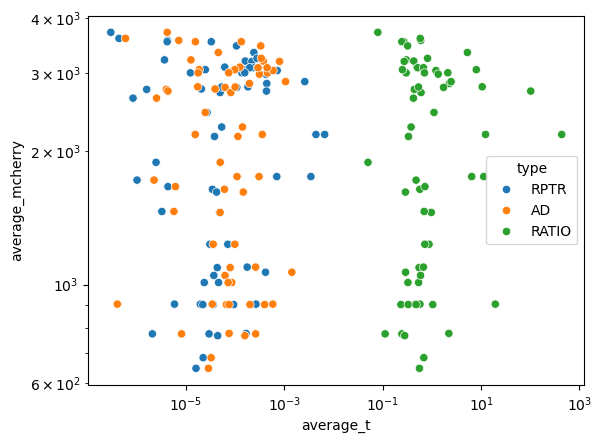

In [32]:
sns.scatterplot(ciberall10xFACSall, x='average_t', y='average_mcherry',hue='type')
# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

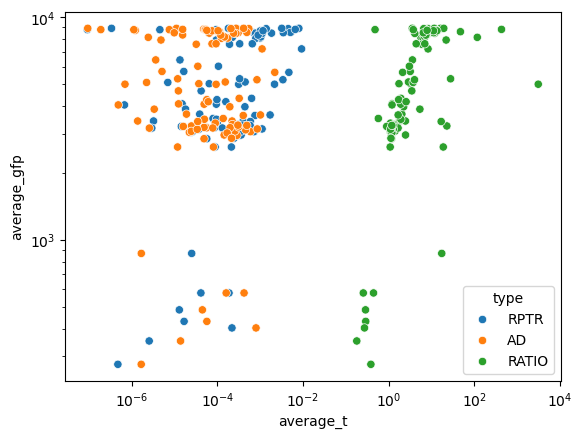

In [33]:
sns.scatterplot(ciberall10xFACSall, x='average_t', y='average_gfp',hue='type')
# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

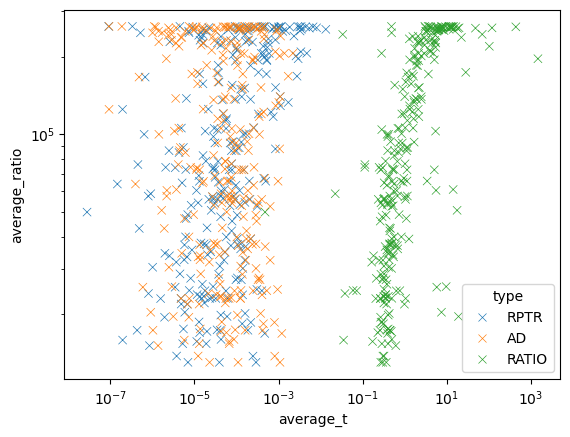

In [78]:
sns.scatterplot(ciberall10xFACSall, x='average_t', y='average_ratio',hue='type',marker='x')
# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

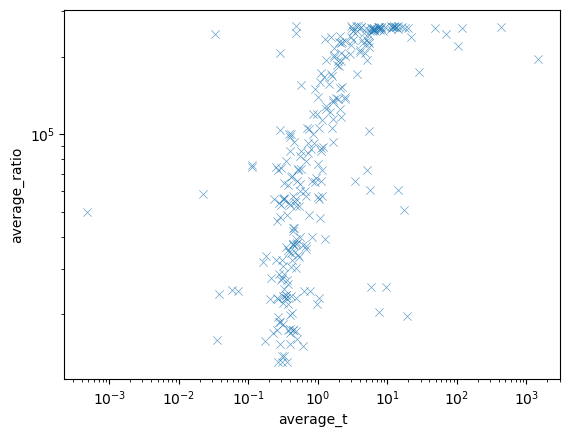

In [24]:
# fig, ax = plt.subplots(1,3, figsize=(15, 5))
# sns.scatterplot(ciberall10xFACSall, x='average_t', y='average_gfp',hue='type', ax=ax[0], legend=False)
# sns.scatterplot(ciberall10xFACSall, x='average_t', y='average_mcherry',hue='type', ax=ax[1], legend=False)
sns.scatterplot(ciberall10xFACSall[ciberall10xFACSall['type']=='RATIO'], x='average_t', y='average_ratio', marker='x', alpha=0.7 )
plt.xscale('log')
plt.yscale('log')
# # Set log scale for all subplots
# for a in ax:
#     a.set_xscale("log")
#     a.set_yscale("log")
# fig.show()

In [41]:
t10_ciberall_collapsed = t10_ciberrptr.merge(t10_ciberad, on='index_x', how='outer', suffixes=('_rptr', '_ad')).merge(t10_ciberratio, on='index_x', how='outer')
t10_ciberall_collapsed = t10_ciberall_collapsed.drop(columns=['Tile_rptr', 'Tile_ad'])
t10_ciberall_collapsed = t10_ciberall_collapsed.rename(columns={'average_t':'average_t_CIBERratio'})

ciberall10_collapsedxFACSall = t10_ciberall_collapsed.merge(filtered_FACSall, left_on='Tile', right_on='DNAseq')
ciberall10_collapsedxFACSall

,index_x,average_t_rptr,type_rptr,average_t_ad,type_ad,Tile,average_t_CIBERratio,type,DNAseq,average_gfp,average_mcherry,average_ratio
0,AAACCACACTTCGG,8.541241e-05,RPTR,5.644123e-05,AD,TCTAATGCTGCTGGTACTATTTCTCCACAAGATTTGTTGATTCATG...,1.512793,RATIO,TCTAATGCTGCTGGTACTATTTCTCCACAAGATTTGTTGATTCATG...,3190.588365,NaN,NaN
1,AAACCTCTTAGAAA,2.149786e-05,RPTR,1.620275e-05,AD,GGTGATTCTCATCCAGCTGATATGGATTTGTTTGATGAATTTACTG...,1.329382,RATIO,GGTGATTCTCATCCAGCTGATATGGATTTGTTTGATGAATTTACTG...,NaN,NaN,125041.446570
2,AAACTTATCTAGTC,1.644543e-05,RPTR,5.089658e-06,AD,ATTGCTGGTGCTCCATCTGGTACTATTTCTCCACAAGATTTGATGA...,3.212864,RATIO,ATTGCTGGTGCTCCATCTGGTACTATTTCTCCACAAGATTTGATGA...,5713.039007,NaN,NaN
3,AAAGAAGGCCCTGC,7.042276e-04,RPTR,1.094523e-04,AD,TTGACTTCTGATTCATTTGTTGATTCTTTGGTTAATTCTTTGGATG...,6.459683,RATIO,TTGACTTCTGATTCATTTGTTGATTCTTTGGTTAATTCTTTGGATG...,8527.457844,1752.996747,255254.458683
4,AACGAATAAATCGT,9.716937e-05,RPTR,3.258931e-04,AD,AATAATTCTCATAGAAGGAAATCTTCTGTTAATGGTTCTCCAGTTA...,0.299060,RATIO,AATAATTCTCATAGAAGGAAATCTTCTGTTAATGGTTCTCCAGTTA...,NaN,NaN,27210.799795
...,...,...,...,...,...,...,...,...,...,...,...,...
353,TTGACCTGATAGCC,3.320065e-04,RPTR,3.903506e-04,AD,CATGATACTTCTTCTCCATCTATTGGTCCAACTATTTCTCCAAGAG...,0.852057,RATIO,CATGATACTTCTTCTCCATCTATTGGTCCAACTATTTCTCCAAGAG...,NaN,NaN,119746.106082
354,TTGTGTATGCTGGT,5.923559e-06,RPTR,9.186863e-07,AD,GATACTATTGATCCACAAAGATCTTCTTCTCCACCAGTTAATCCAT...,7.464272,RATIO,GATACTATTGATCCACAAAGATCTTCTTCTCCACCAGTTAATCCAT...,NaN,NaN,20348.419393
355,TTTGTCACCTAAAC,1.065953e-04,RPTR,2.180914e-04,AD,TTTACTGCATTTGGTGGTGGTGCTACTACTGCATTCTCTTCTCCAG...,0.488494,RATIO,TTTACTGCATTTGGTGGTGGTGCTACTACTGCATTCTCTTCTCCAG...,NaN,NaN,39299.149182
356,TTTTGAATAAACGC,2.787339e-04,RPTR,3.408295e-04,AD,ACTCCAACTATGGCTTTGCAAGGTATGCATCATAACTTTCATGCTC...,0.817795,RATIO,ACTCCAACTATGGCTTTGCAAGGTATGCATCATAACTTTCATGCTC...,NaN,3239.649931,NaN


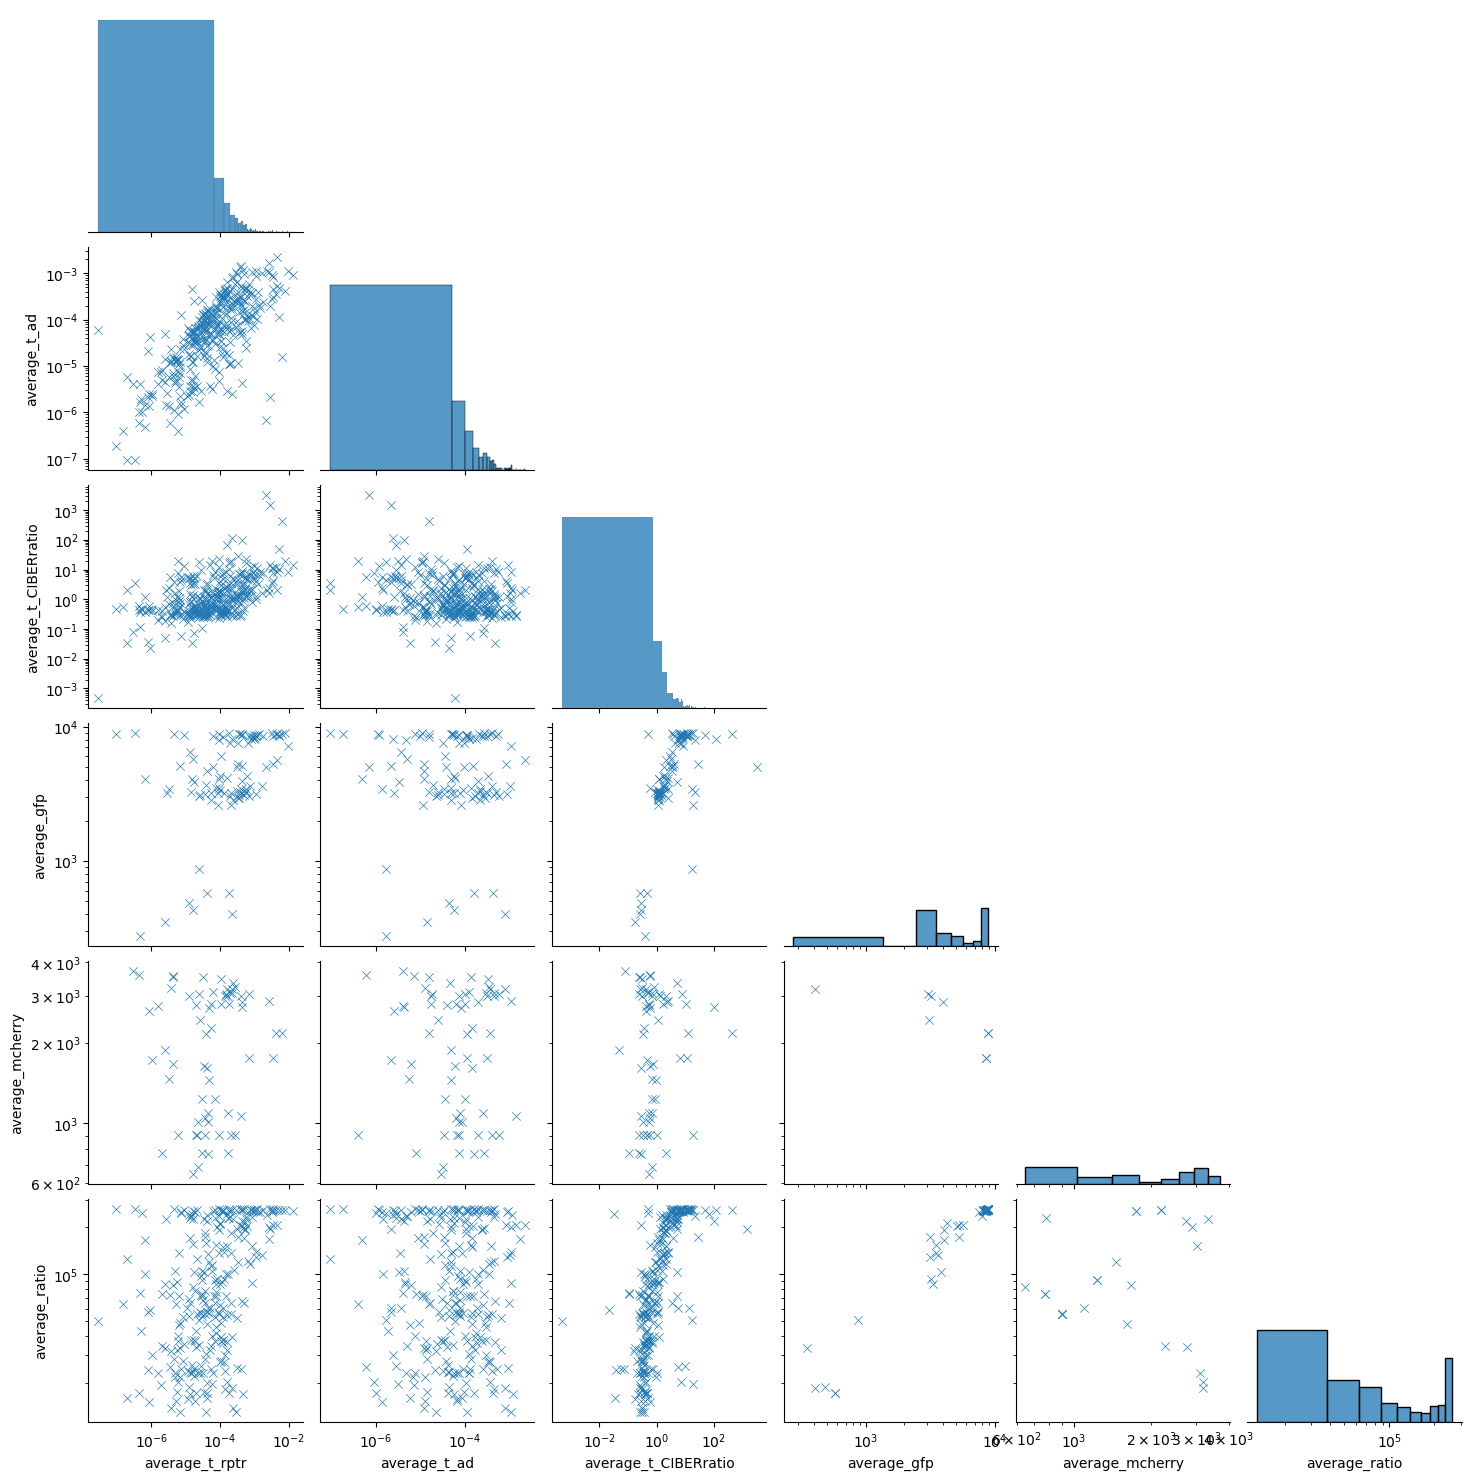

In [42]:
p = sns.pairplot(ciberall10_collapsedxFACSall, plot_kws={"marker": "x"}, corner=True,)
p.set(xscale="log", yscale="log")

In [10]:
# def ciber_prep(fpath, runtype):
#     """
#     fpath = str, filepath to csv file
#     runtype = str, {'RPTR', 'AD', 'RATIO'}
#     """
#     df = pd.read_csv(fpath, index_col=0)
#     cols = df.select_dtypes(include='float').columns.tolist()
#     df['average_t'] = df[cols].mean(axis=1)
#     df = df.drop(columns=cols)
#     df['type'] = runtype

#     return df


# def ciber_combine(time):
#     """
#     time: int, which time point for analysis
#     """
#     # get filepaths 
#     fpath_list = glob.glob(f"t{time}*_norm_nans.csv")
#     print(fpath_list)

#     df_list = []
#     # prep dfs
#     for f in fpath_list:
#         if f.startswith(f't{time}r_'):
#             # print(f,'is rptr')
#             df_r = ciber_prep(f, 'RPTR')
#         elif f.startswith(f't{time}a_'):
#             # print(f,'is ad')
#             df_a = ciber_prep(f, 'AD')
#         elif f.startswith(f't{time}ratio_'):
#             # print(f,'is ratio')
#             df_o = ciber_prep(f, 'RATIO')
#     df_list.append(df_r)
#     df_list.append(df_a)
#     df_list.append(df_o)
#     # print(df_list[0].head())

#     df_all = pd.concat(df_list)
#     # print(df_all.head())
#     ciberallxFACSall = df_all.merge(filtered_FACSall, left_on='Tile', right_on='DNAseq')
#     # print(ciberallxFACSall.head())

#     fig, ax = plt.subplots(1,3, figsize=(15, 5))
#     sns.scatterplot(ciberall10xFACSall, x='average_t', y='average_gfp',hue='type', ax=ax[0], legend=False,marker='x')
#     sns.scatterplot(ciberall10xFACSall, x='average_t', y='average_mcherry',hue='type', ax=ax[1], legend=False,marker='x')
#     sns.scatterplot(ciberall10xFACSall, x='average_t', y='average_ratio',hue='type', ax=ax[2],marker='x')
#     # Set log scale for all subplots
#     for a in ax:
#         a.set_xscale("log")
#         a.set_yscale("log")
#     fig.show()
    
#     df_all_collapsed = df_r.merge(df_a, on='index_x', how='outer', suffixes=('_rptr', '_ad')).merge(df_o, on='index_x', how='outer')
#     df_all_collapsed = df_all_collapsed.drop(columns=['Tile_rptr', 'Tile_ad'])
#     df_all_collapsed = df_all_collapsed.rename(columns={'average_t':'average_t_CIBERratio'})
#     # print(df_all_collapsed.head())
#     df_all_collapsedxFACSall = df_all_collapsed.merge(filtered_FACSall, left_on='Tile', right_on='DNAseq')
#     # print(df_all_collapsedxFACSall.head())

#     p = sns.pairplot(df_all_collapsedxFACSall, plot_kws={"marker": "x"}, corner=True,)
#     p.set(xscale="log", yscale="log")
#     plt.show()

In [11]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Updated correlation annotation function to handle NaNs
def corrfunc(x, y, **kws):
    # Drop NaN values from both x and y
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    if np.sum(mask) == 0:
        r = 0  # If no valid data points, set correlation to 0
    else:
        # Compute Spearman correlation with non-NaN data
        r, _ = spearmanr(x[mask], y[mask])
    
    # Annotate plot with Spearman correlation value
    ax = plt.gca()
    ax.annotate(f'Spearman r = {r:.2f}', xy=(0.5, 0.1), xycoords=ax.transAxes, ha='center', fontsize=12)

# Function to prepare data (unchanged)
def ciber_prep(fpath, runtype):
    """
    fpath = str, filepath to csv file
    runtype = str, {'RPTR', 'AD', 'RATIO'}
    """
    df = pd.read_csv(fpath, index_col=0)
    cols = df.select_dtypes(include='float').columns.tolist()
    df['average_t'] = df[cols].mean(axis=1)
    df = df.drop(columns=cols)
    df['type'] = runtype

    return df

# Updated function with pairplot using Spearman correlation annotation
def ciber_combine(time):
    """
    time: int, which time point for analysis
    """
    # Get filepaths 
    fpath_list = glob.glob(f"t{time}*_norm_nans.csv")
    print(fpath_list)

    df_list = []
    # Prep dataframes
    for f in fpath_list:
        if f.startswith(f't{time}r_'):
            df_r = ciber_prep(f, 'RPTR')
        elif f.startswith(f't{time}a_'):
            df_a = ciber_prep(f, 'AD')
        elif f.startswith(f't{time}ratio_'):
            df_o = ciber_prep(f, 'RATIO')

    df_list.append(df_r)
    df_list.append(df_a)
    df_list.append(df_o)

    # Merge all the dataframes
    df_all = pd.concat(df_list)
    ciberallxFACSall = df_all.merge(filtered_FACSall, left_on='Tile', right_on='DNAseq')

    # Create scatter plots for visualizing 'average_t' against GFP, mCherry, and ratio
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    sns.scatterplot(data=ciberallxFACSall, x='average_t', y='average_gfp', hue='type', ax=ax[0], legend=False, marker='x')
    sns.scatterplot(data=ciberallxFACSall, x='average_t', y='average_mcherry', hue='type', ax=ax[1], legend=False, marker='x')
    sns.scatterplot(data=ciberallxFACSall, x='average_t', y='average_ratio', hue='type', ax=ax[2], marker='x')

    # Set log scale for all subplots
    for a in ax:
        a.set_xscale("log")
        a.set_yscale("log")

    plt.show()

    # Further merge dataframes and prepare for pairplot
    df_all_collapsed = df_r.merge(df_a, on='index_x', how='outer', suffixes=('_rptr', '_ad')).merge(df_o, on='index_x', how='outer')
    df_all_collapsed = df_all_collapsed.drop(columns=['Tile_rptr', 'Tile_ad'])
    df_all_collapsed = df_all_collapsed.rename(columns={'average_t': 'average_t_CIBERratio'})
    
    # Merge with FACS data
    df_all_collapsedxFACSall = df_all_collapsed.merge(filtered_FACSall, left_on='Tile', right_on='DNAseq')

    # Create a pairplot with Spearman correlation annotations
    p = sns.pairplot(df_all_collapsedxFACSall, plot_kws={"marker": "x", "alpha": 0.6}, corner=True)
    
    # Apply log scale and annotation with Spearman correlation
    p.map_lower(corrfunc)
    p.set(xscale="log", yscale="log")

    plt.show()


['t10a_norm_nans.csv', 't10r_norm_nans.csv', 't10ratio_norm_nans.csv']


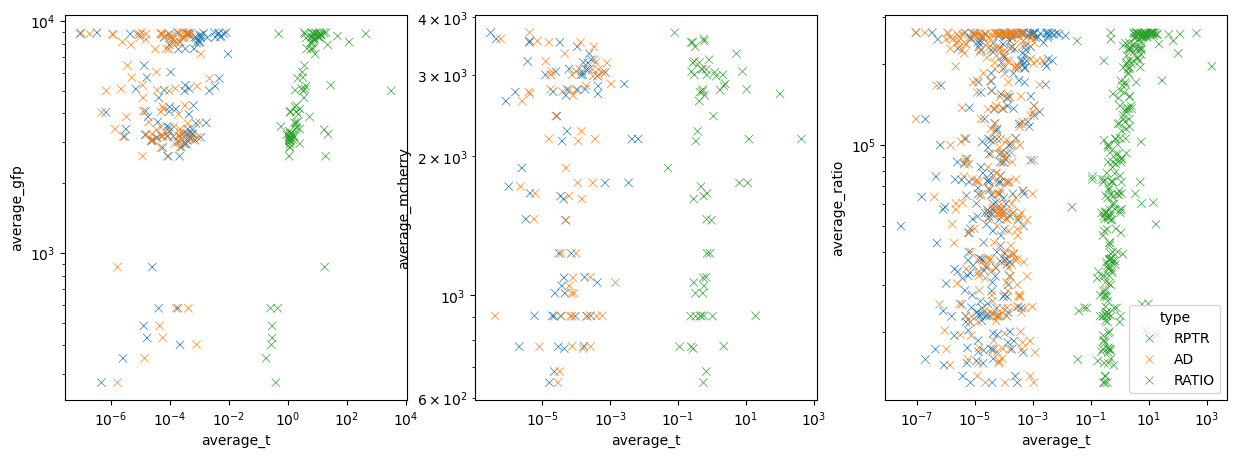

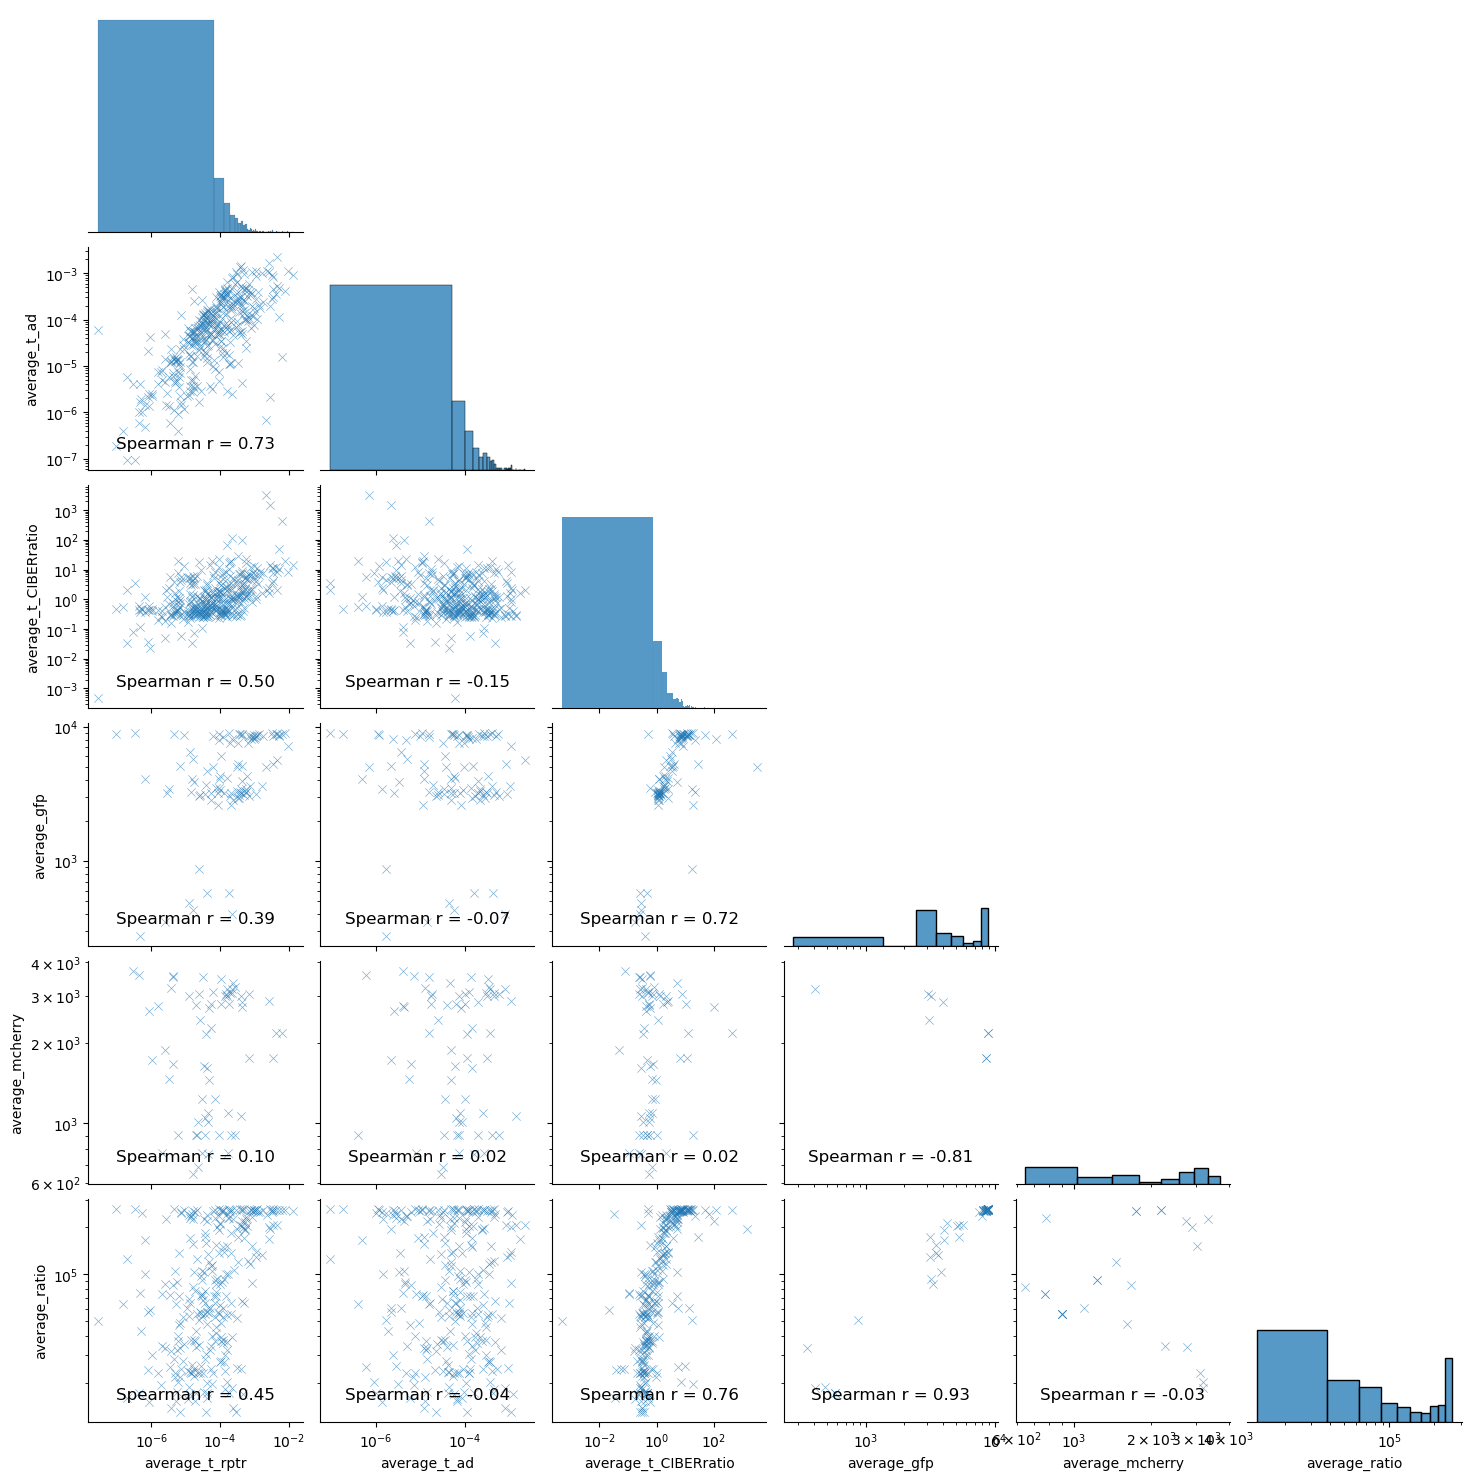

In [12]:
ciber_combine('10')

In [52]:
test_time = 5
print(glob.glob(f"t{test_time}*_norm_nans.csv"))

['t5a_norm_nans.csv', 't5r_norm_nans.csv', 't5ratio_norm_nans.csv']


['t5a_norm_nans.csv', 't5r_norm_nans.csv', 't5ratio_norm_nans.csv']


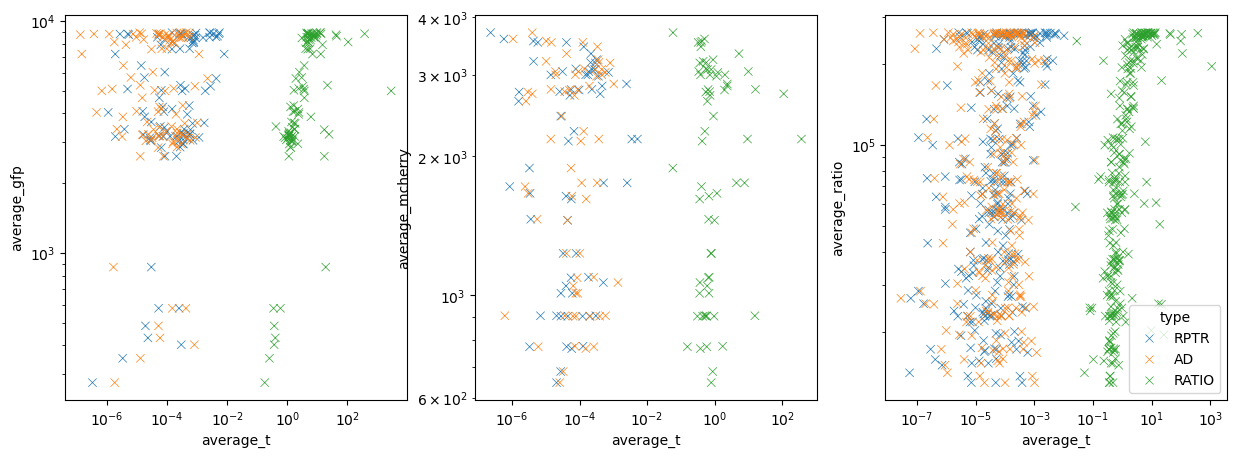

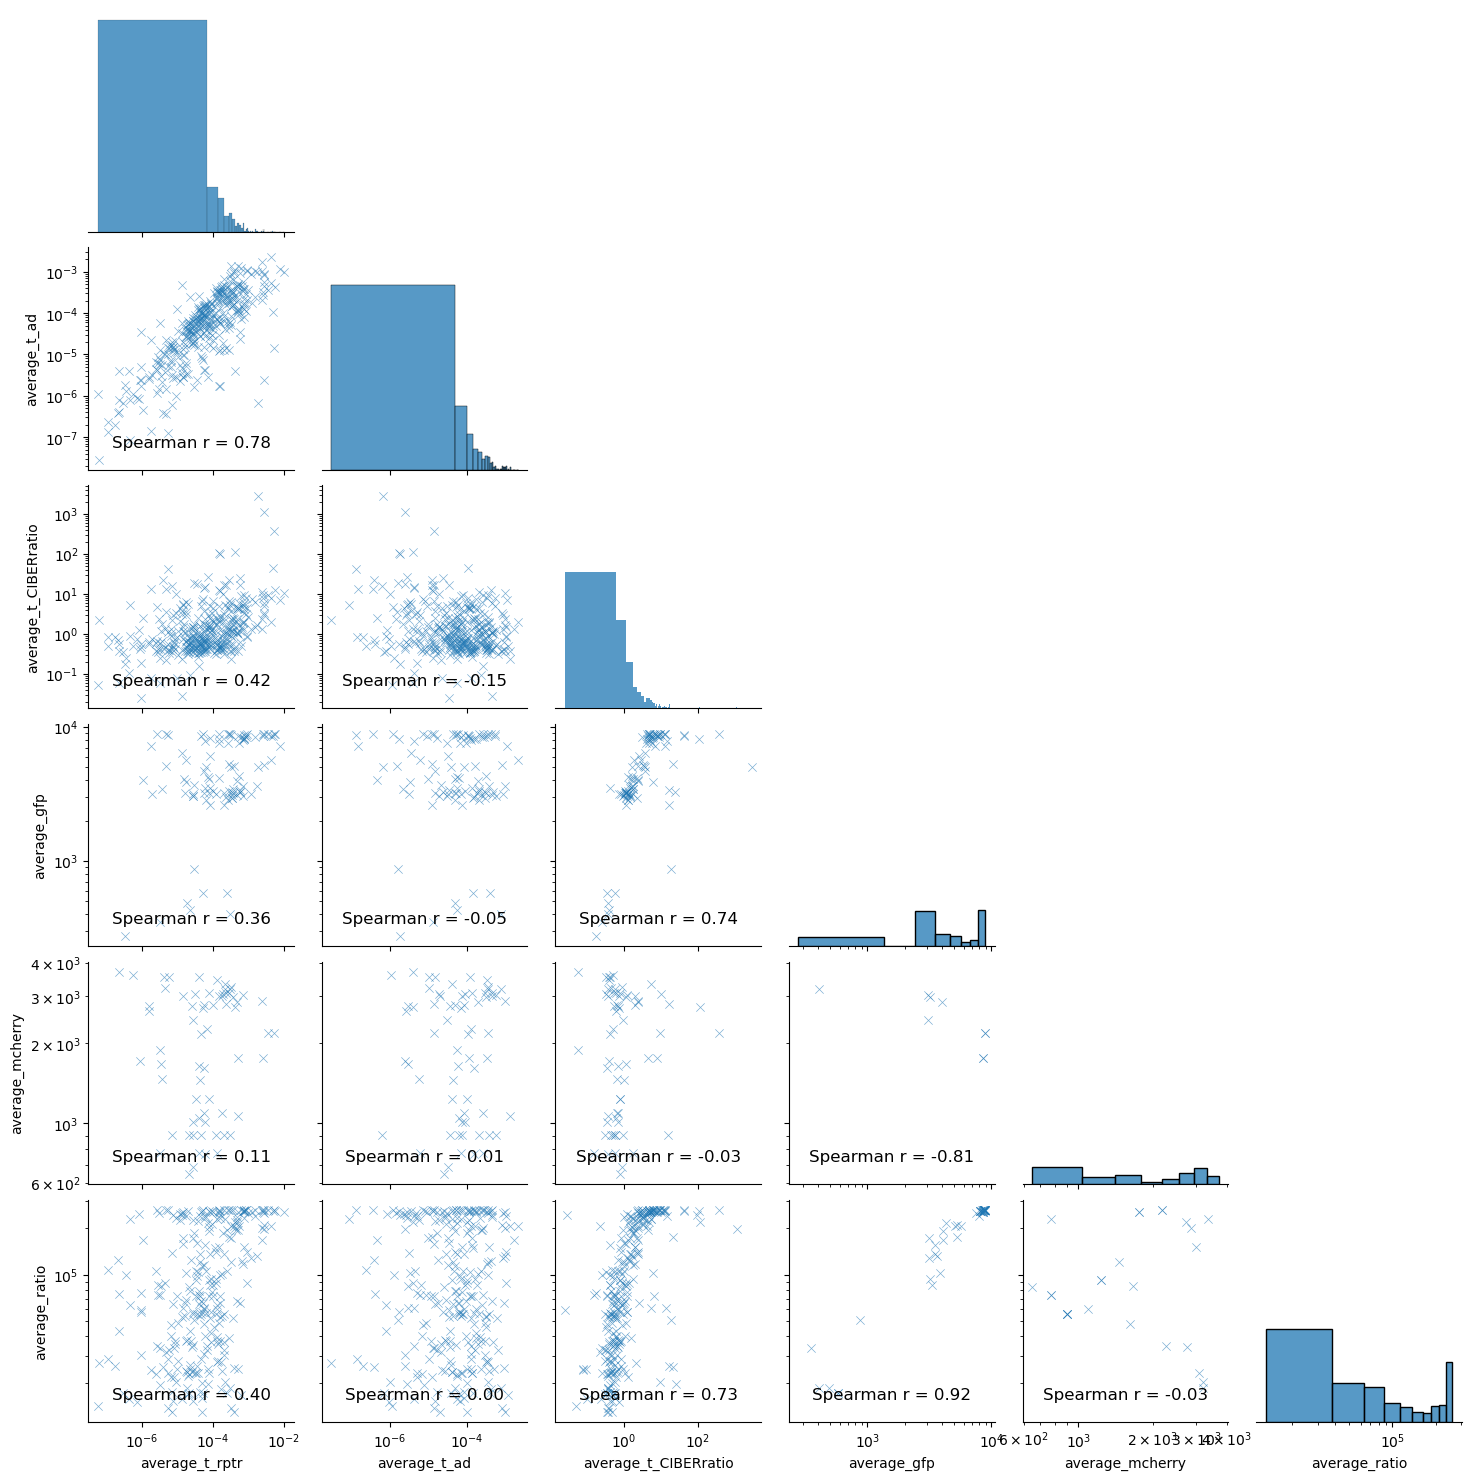

In [13]:
ciber_combine('5')

['t15ratio_norm_nans.csv', 't15a_norm_nans.csv', 't15r_norm_nans.csv']


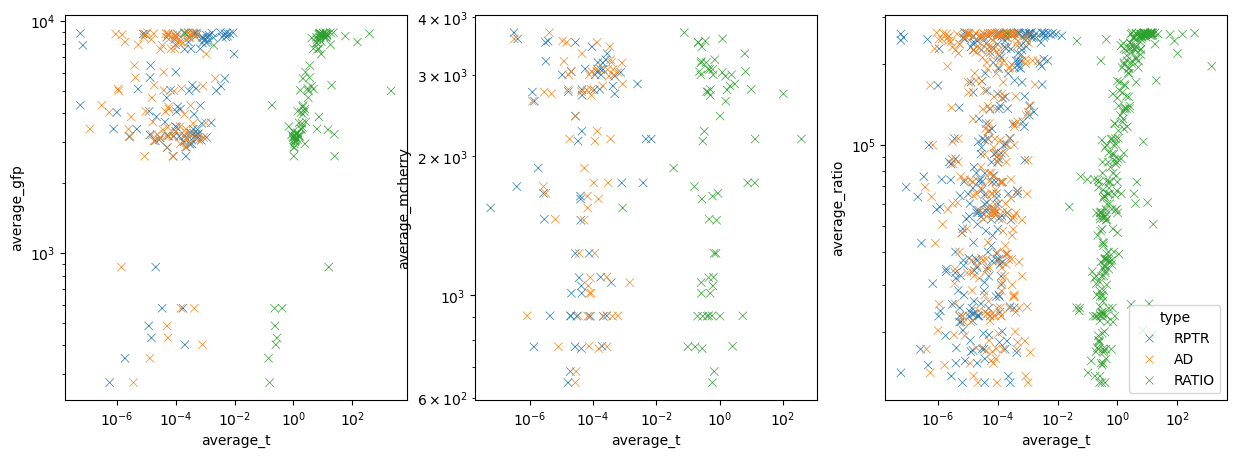

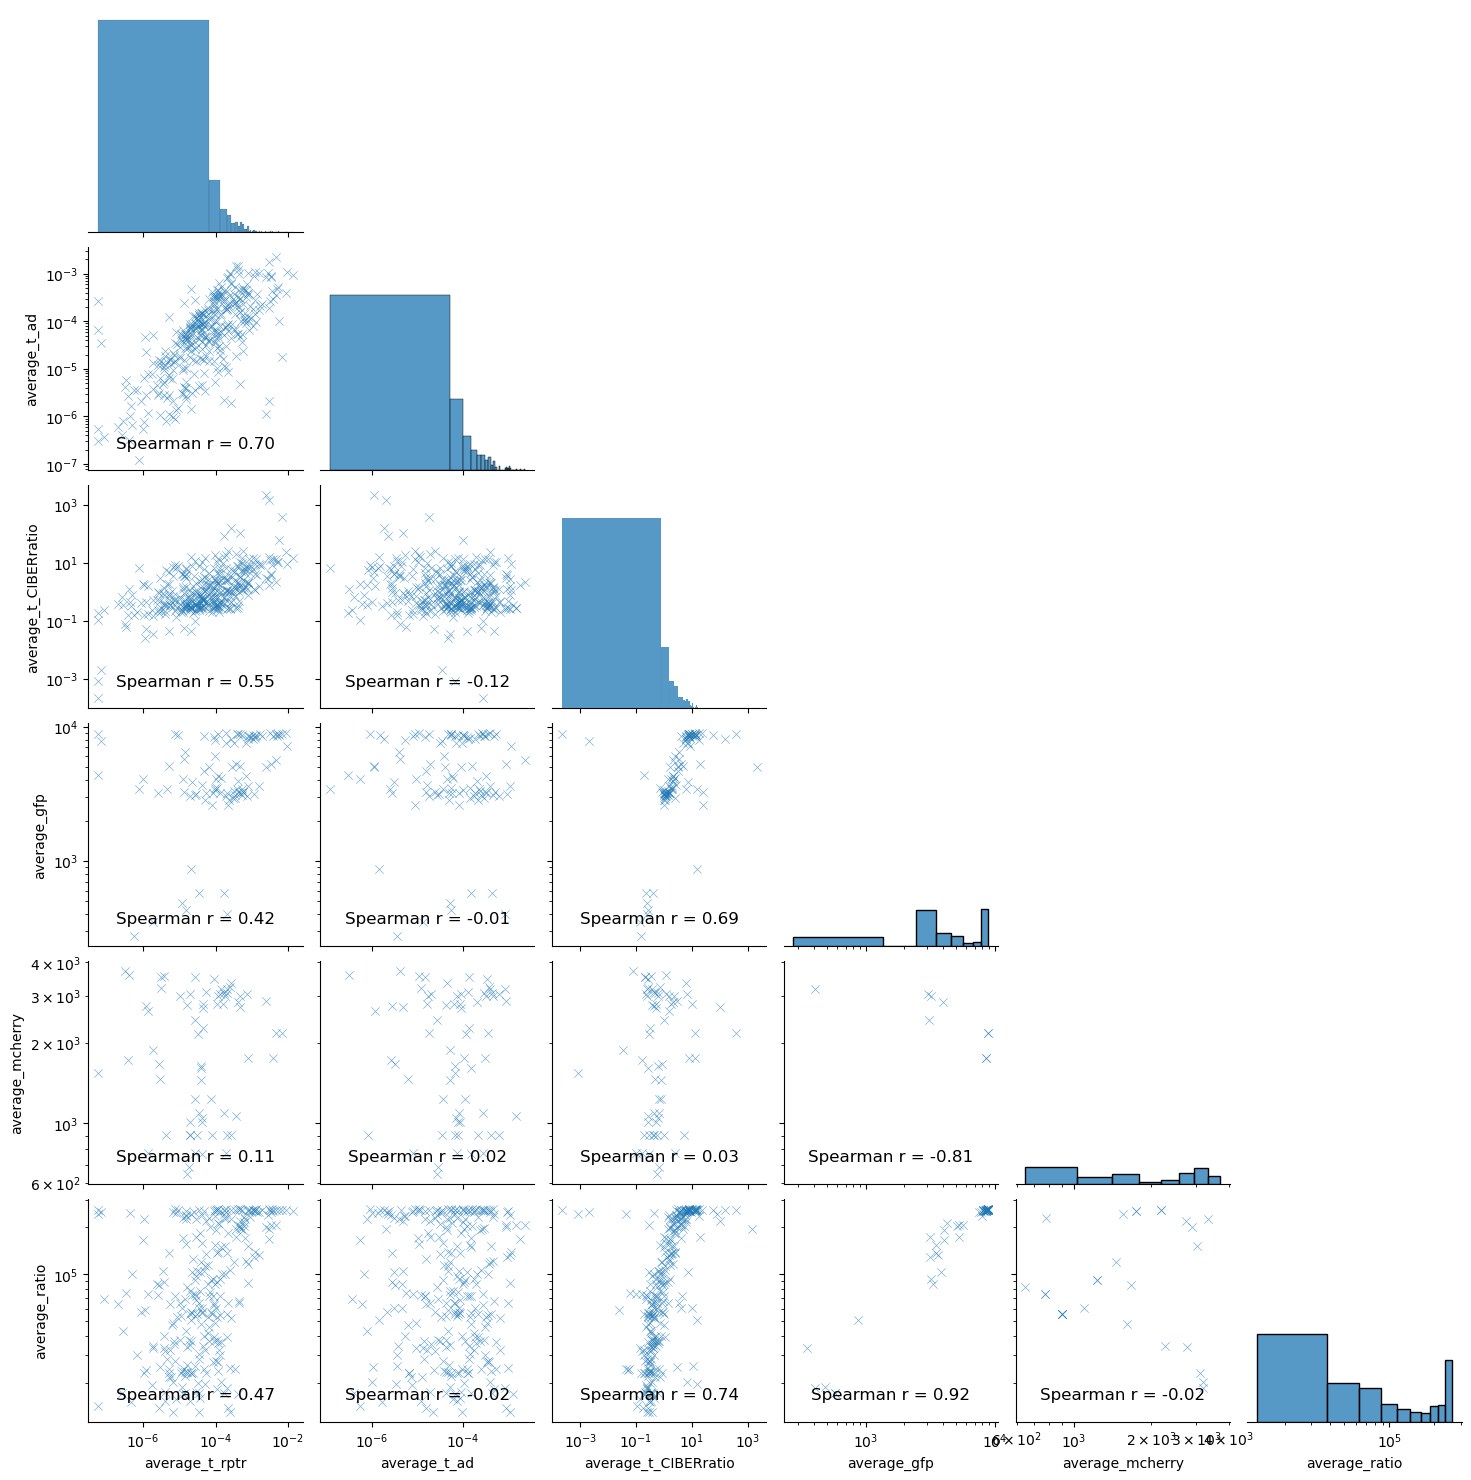

In [14]:
ciber_combine('15')

['t30r_norm_nans.csv', 't30a_norm_nans.csv', 't30ratio_norm_nans.csv']


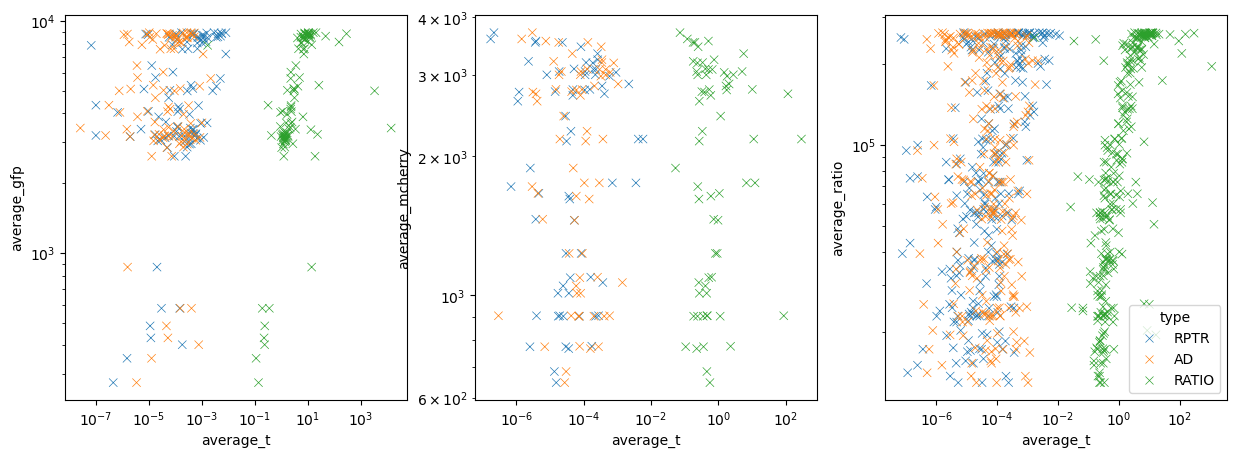

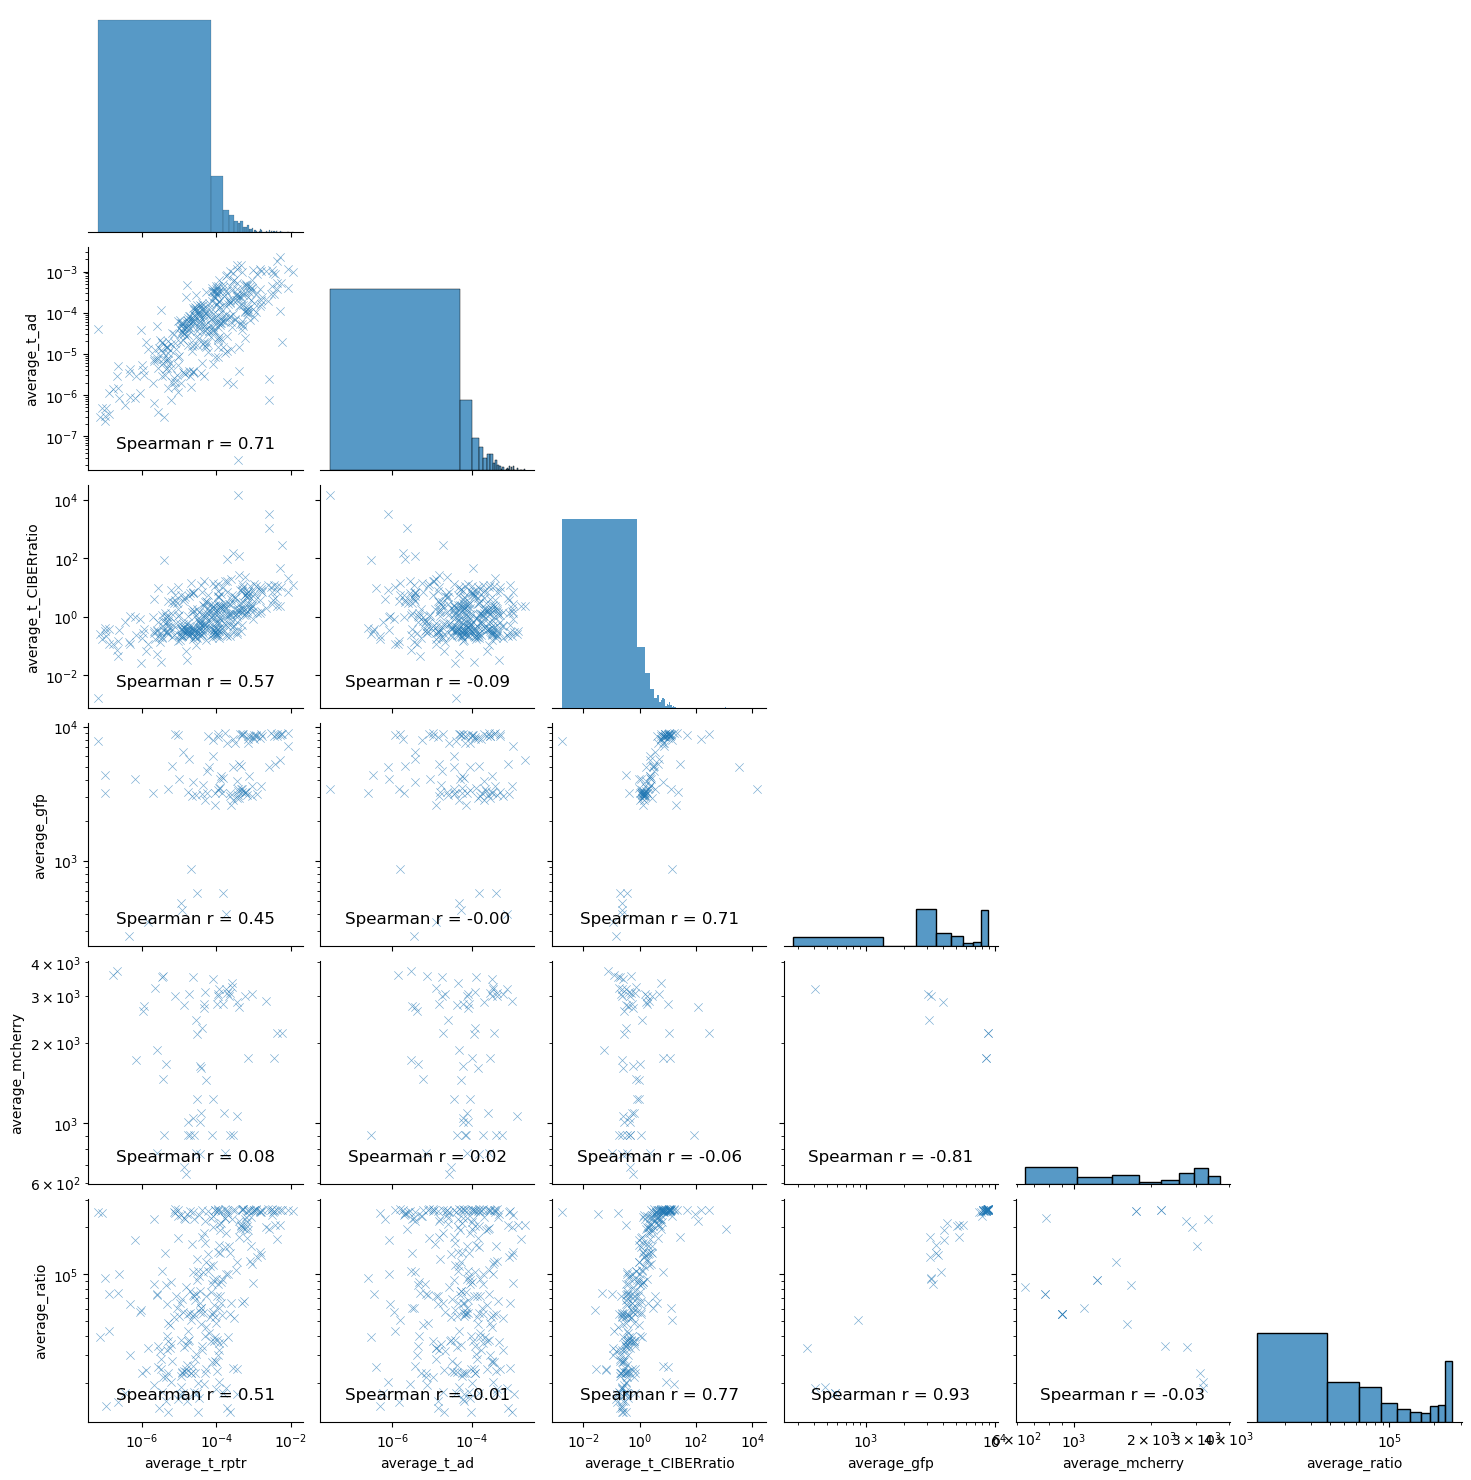

In [15]:
ciber_combine('30')

['t180r_norm_nans.csv', 't180a_norm_nans.csv', 't180ratio_norm_nans.csv']


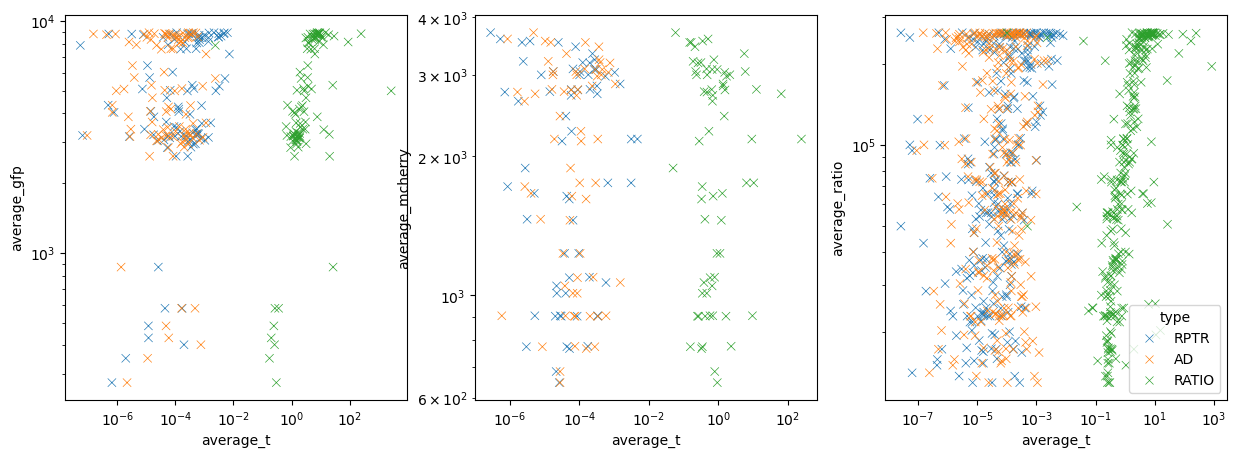

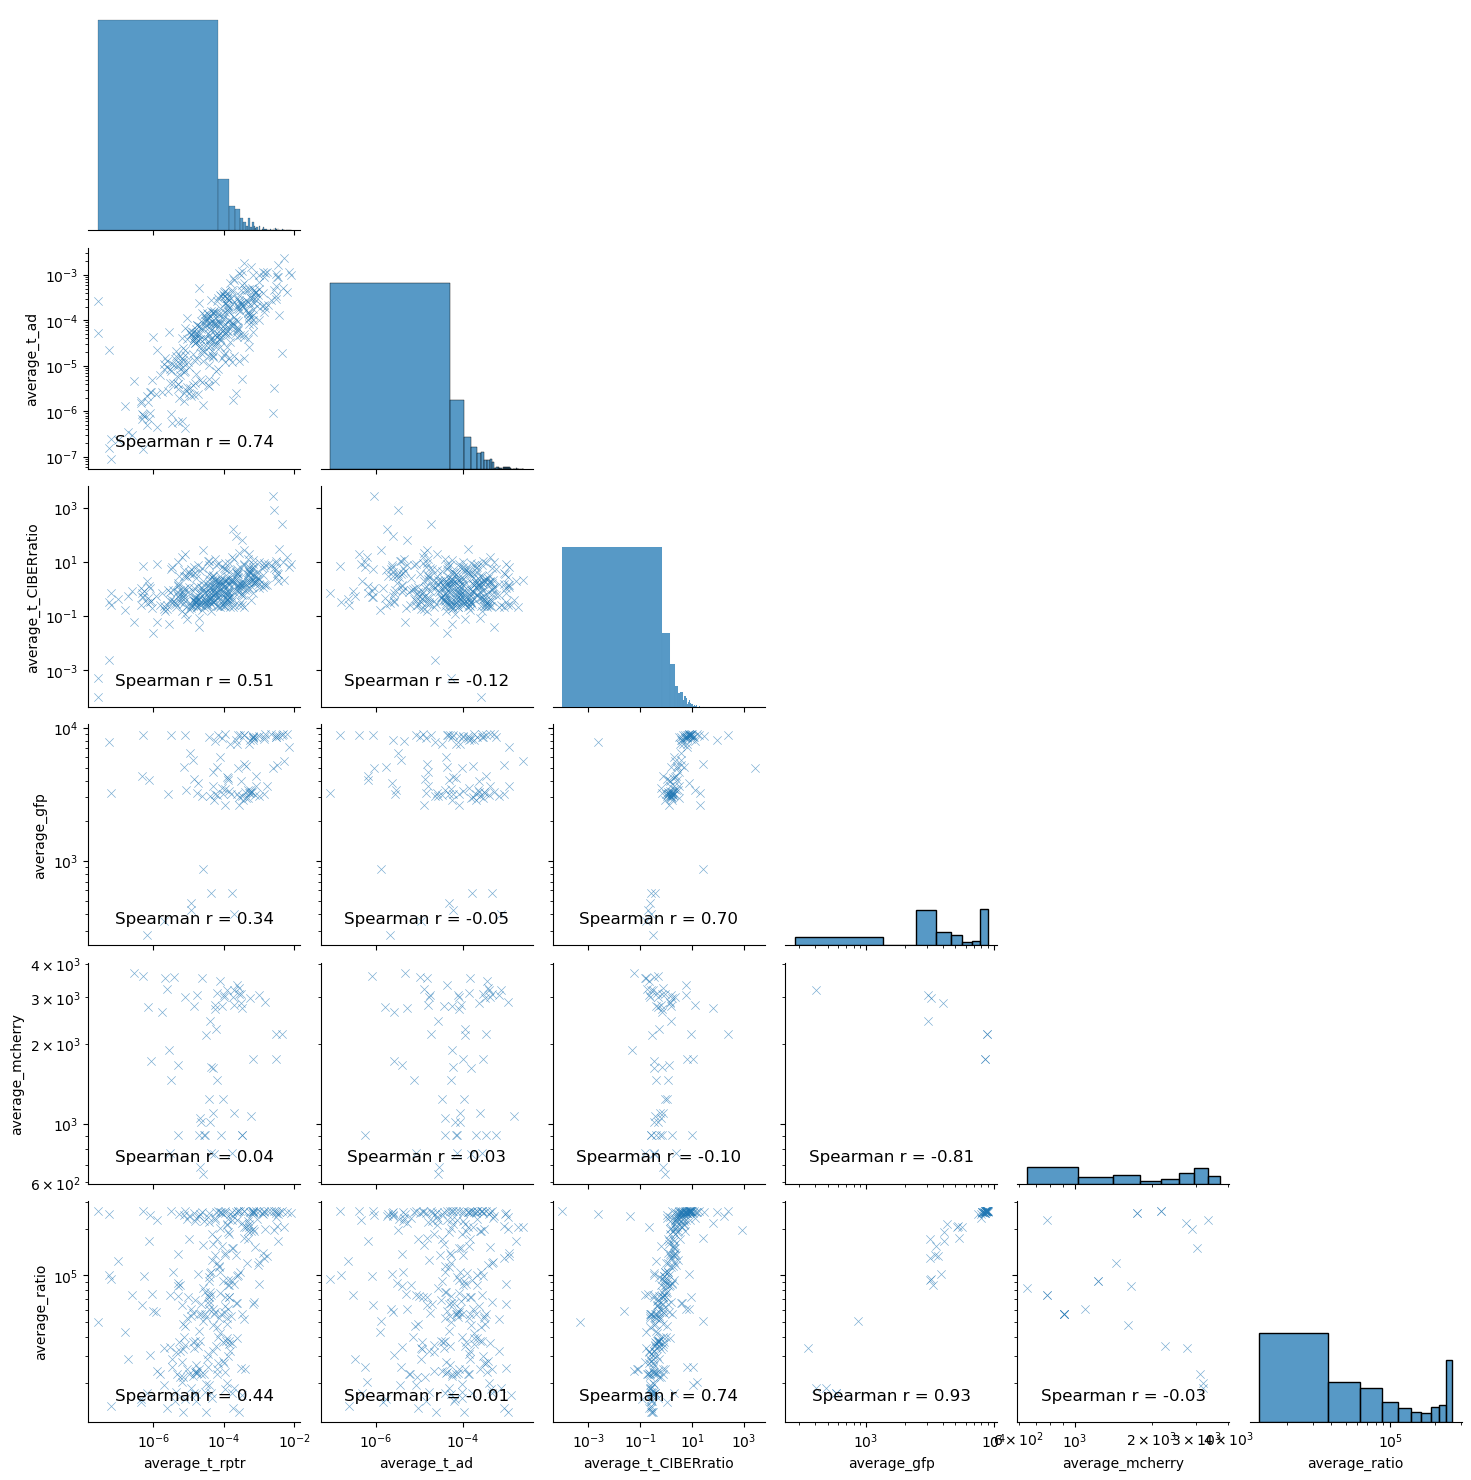

In [16]:
ciber_combine('180')

['t240ratio_norm_nans.csv', 't240r_norm_nans.csv', 't240a_norm_nans.csv']


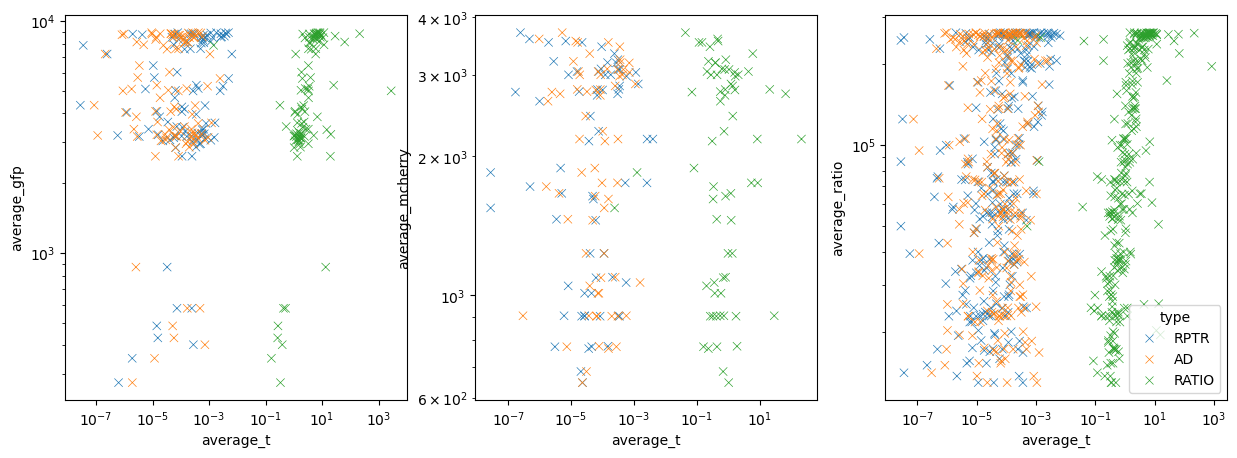

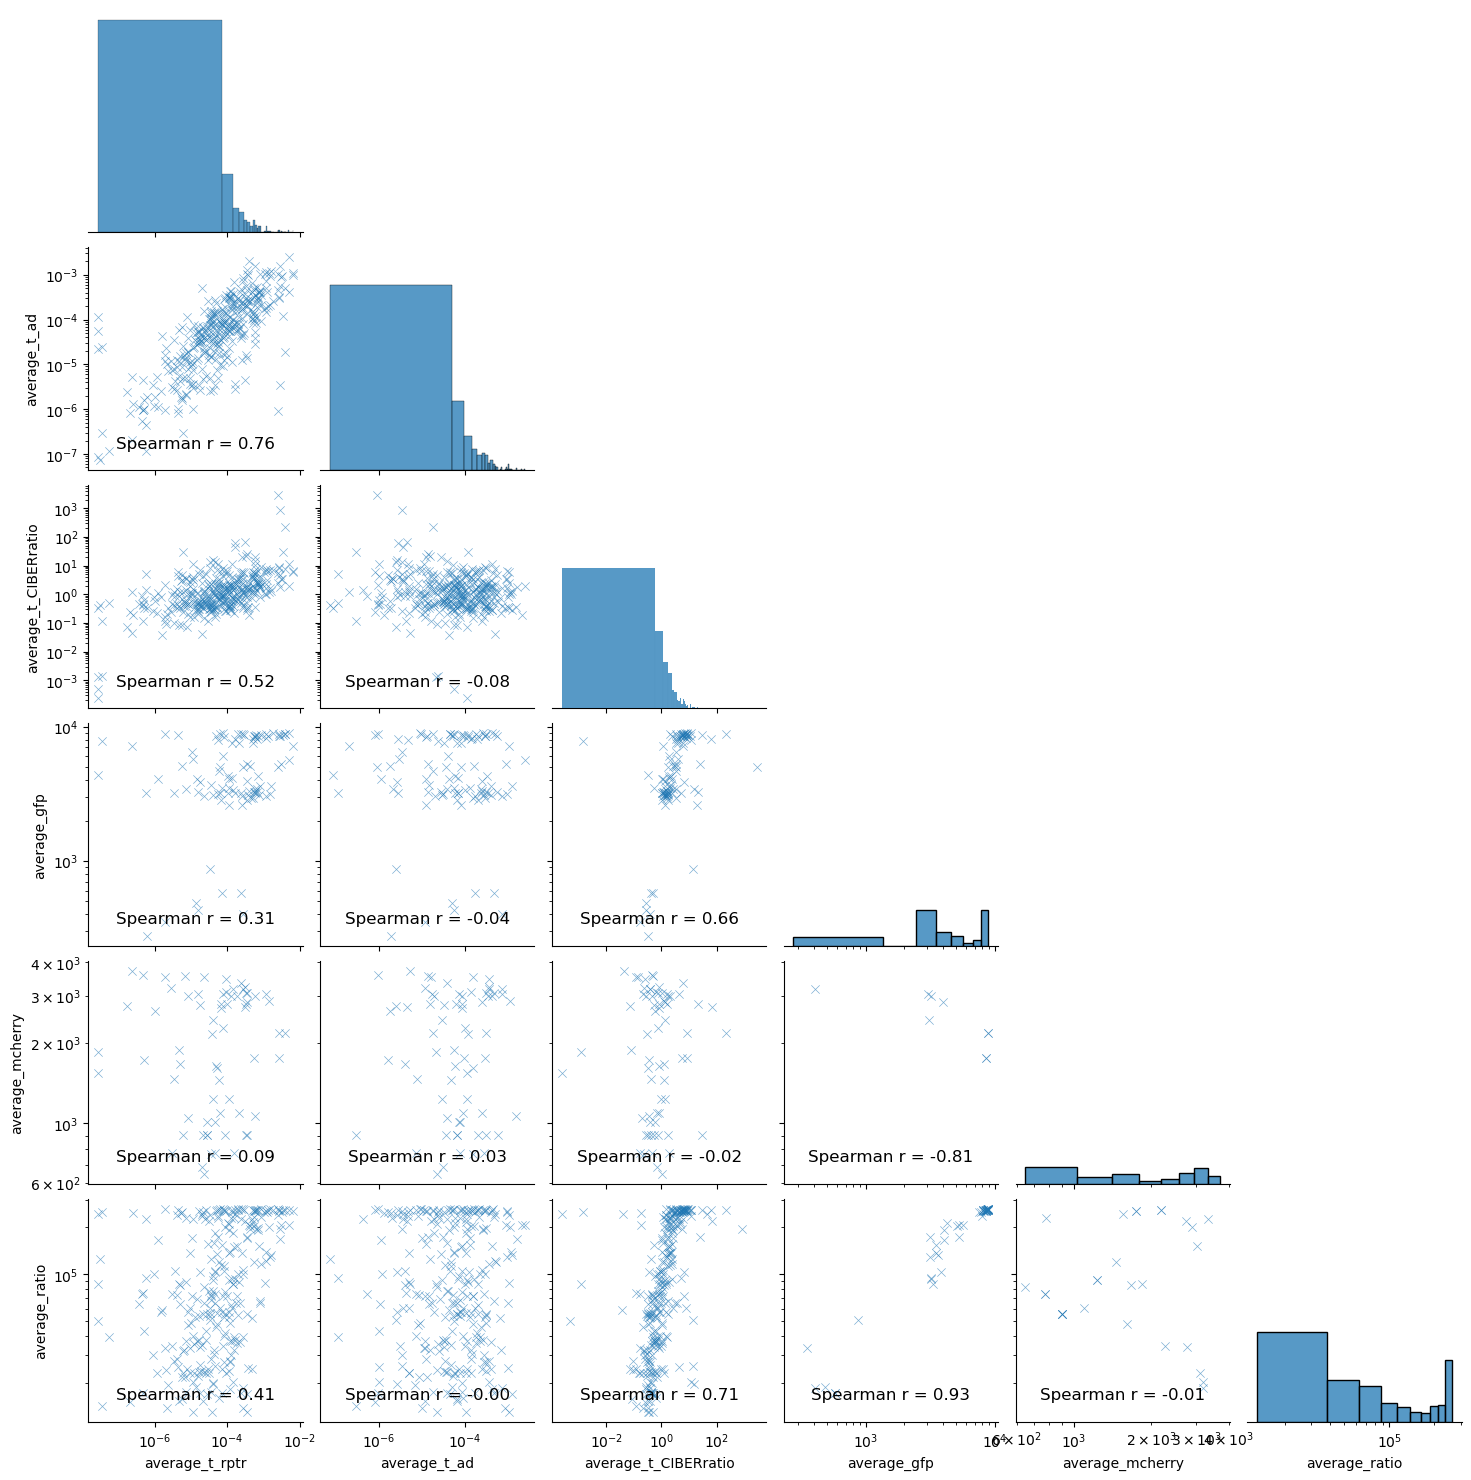

In [17]:
ciber_combine('240')